<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/Exploration_quest/exploration_3/xp3_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploration 3. Semantic Segmentation

**Goal**

* Semantic Segmentation 이해하기
* 딥러닝을 적용해서 핸드폰의 인물사진 모드 시현하기

**Index**

    5-1. Introduction
    5-2. 사진 준비
    5-3. What's Segmentation?
    5-4. Semantic Segmentation
    5-5. 배경 흐리게 하기
    5-6. 흐린 배경과 원본 합성하기
    

### 5-1. Introduction

피사체를 가깝게 찍을 때 배경이 흐려지는 효과를 경험해 보신 적이 있나요? 보통은 DSLR이나 Mirrorless와 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과입니다. 하지만 피사체를 충분히 가까운 거리에 두고 촬영 한다면 전화기 카메라에서도 비슷한 효과를 낼 수 있습니다. 특히 2개 이상의 렌즈를 탑재한 최신 전화기에서는 Portrait mode가 지원됩니다. 전화기 카메라의 인물사진 모드는 듀얼 카메라를 이용하여 DSLR의 아웃포커싱 기능을 흉내 냅니다. 물론 인물사진 모드의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다릅니다. 한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱' 이라고 표현하죠? 하지만 아웃포커싱은 한국에서만 사용하는 용어입니다. 정확한 표현은 얕은 피사계 심도 Shallow depth of field 또는 Shallow focus 라고 합니다.

### 5-2. 사진 준비

사진을 준비하겠습니다! 사용할 디렉터리 구조는 아래와 같습니다.

```
  aiffel/human_segmentation
    ├── models
    │   └── deeplabv3_xception_tf_dim_ordering_tf_kernels.h5
    │
    └── images
        └── hi.png
```

In [ ]:
# cv2 - OpenCV lib
# pixellib - image/video segmentation lib
# pixellib.semantic - semantic segmentation lib

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print("Are you ready?")

Are you ready?


(1316, 976, 3)


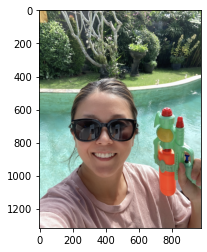

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hi.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 5-3. What's Segmentation?

**What's Segmentation?**  
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 `Image Segmentation` 이라고 합니다. Image Segmentation은 모든 픽셀에 `label`을 할당하고, label이 같은 객체들은 "공통적인 특징"을 가진다 라고 가정합니다. 이 때, 공통 특징이란 물리적인 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수도 있는 것이죠.

**Watershed segmentation**  
이미지에서 영역을 분할하는 가장 간단한 방법은 객체의 '경계'를 나누는 것입니다. 이미지를 Grayscale로 변환하면 0에서 255 사이의 값을 가집니다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있어요. 가령 수조 안의 낮은 부분부터 서서히 물을 채워 나간다고 생각하면 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 됩니다. 그 부분을 경계로 만들면 객체를 서로 구분할 수 있는 원리입니다. 자세한 내용은 [Watershed 알고리즘을 이용한 이미지 분할
](https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)을 참고해 주세요.

**Semantic Segmentation**  
`Semantic Segmentation`은 물리적 의미 단위로 이미지를 인식합니다.

**Instance Segmentation**  
여러 사람이 하나의 이미지에 등장할 때 사람들을 개인으로 분할하여 각각 다른 label을 가지도록 인식하는 것이 `Instance Segmentation`의 목표입니다

### 5-4. Semantic Segmentation

Segmentation 문제에는 FCN, SegNet, U-Net 등의 다양한 모델이 사용됩니다. 오늘은 그 중에서 `DeepLab v3+` 이라는 Segmentation 모델을 이용하겠습니다. DeepLab에 대한 자세한 설명은 [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://bloglunit.wordpress.com/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)를 참고해 주세요.

**Q. DeepLab에서 atrous convolution을 사용하는 이유는 무엇인가요?**
```
Atrous convolution은 입력 이미지의 특정 위치에 직접적으로 가중치를 적용하는 합성곱 기법이에요. 커널 사이의 간격을 두고 진행되므로, 보다 넓은 영역의 정보를 효과적으로 캡처할 수 있어요. 세그멘테이션 작업에서는 객체의 경계와 구조를 정확하게 분리하고 인식하는 것이 중요합니다. Atrous convolution은 다양한 스케일의 정보를 효과적으로 사용하여 세그멘테이션 모델의 정확도를 향상시키고자 고안된 방법 중 하나입니다.
```

**Q. Depthwise separable convolution은 어디에서 처음 사용한 것이며, 이 구조의 효율성에 대해 설명해 주세요. [Xception 참고자료.](https://arxiv.org/abs/1610.02357)**
```
Depthwise separable convolution은 계산 효율성과 모델 파라미터 수를 줄이면서도 비교적 좋은 성능을 제공하는 합성곱 연산 방법입니다. 이 구조는 연산량을 줄이고 모델의 경량화를 가능하게 함으로써 모바일 및 임베디드 기기에서 딥러닝 모델을 실행하는 데 특히 유용해요. Depthwise separable convolution의 개념은 2014년에 François Chollet이 제안한 Xception 모델에서 처음으로 적용되었습니다. Xception은 Inception 모델의 아이디어를 확장하고, Inception 모델의 인셉션 블록에서 사용되는 기본 합성곱을 Depthwise Separable Convolution으로 대체하여 더 효율적인 구조를 제안했습니다.
```

`DeepLab` 모델을 준비하겠습니다. `PixelLib` 를 이용하면 편하게 사용할 수 있습니다.

In [ ]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib model url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fbb4fc140d0>)

`PixelLib`을 활용하여 `Segmentation` 모델을 생성합니다.

In [ ]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

생성한 모델에 이미지를 입력하겠습니다. [The PASCAL Visual Object Classes](http://host.robots.ox.ac.uk/pascal/VOC/) 참고.

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path)

`PASCAL VOC` 데이터의 `label 종류`는 아래와 같습니다.

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 인물 모드 사진 제작을 위해 인덱스 15의 `person` label을 추출하겠습니다.

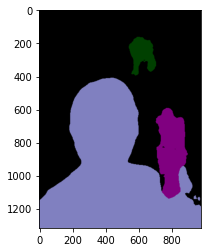

In [ ]:
plt.imshow(output)
plt.show()

In [ ]:
segvalues

{'class_ids': array([ 0,  5, 15, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [ ]:
# segvalues의 class_ids로 pacalvoc label 출력

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person
pottedplant


세그멘테이션이 진행 된 결과가 각각 다른 색상으로 나타납니다. `segvalues` 에는 class_ids와 masks가 있습니다.  
이제 객체의 결과에 어떤 색상이 나타나는지 알아보겠습니다.

In [ ]:
# Color-map

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [ ]:
# 인덱스 15의 person label

colormap[15]

array([192, 128, 128])

이미지의 객체 중에서 사람 외의 다른 객체를 찾고 싶다면 `colormap[class_id]`를 활용하여 쉽게 찾을 수 있습니다.  
한편, 결과 이미지는 BGR 순서로 채널이 배치 되어 있지만, `colormap`은 `RGB` 순서임을 주의해야 합니다!  

In [ ]:
# colormap의 배열은 RGB, output의 배열은 BGR

seg_color = (128, 128, 192) # 색상순서 변경

`seg_color`로 이뤄진 마스크를 만들어 봅시다.

(1316, 976)


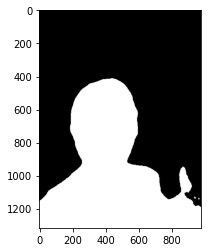

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
# seg_color 값이 person의 값이므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함

seg_map = np.all(output == seg_color, axis = -1)
print(seg_map.shape)
plt.imshow(seg_map, cmap = 'gray')
plt.show()

어떤가요? 채널 정보가 사라졌습니다! 아래의 행렬처럼 `객체가 있는 위치는 1(True)`, `그 외에는 0(False)`인 배열이 되었습니다.

```
[[ 0 1 1 0 0 0 1 1 0 ],
 [ 1 1 1 1 0 1 1 1 1 ],
 [ 0 1 1 1 1 1 1 1 0 ],
 [ 0 0 1 1 1 1 1 0 0 ],
 [ 0 0 0 1 1 1 0 0 0 ]]
```


원본 이미지와 마스크를 합성하여 세그멘테이션이 얼마나 잘 수행 되었는지 확인해 봅시다.

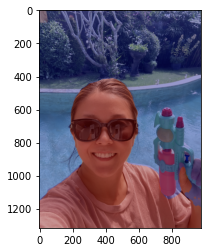

In [ ]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 5-5. 배경 흐리게 하기

`blur()` 함수를 이용하여 배경을 흐리게 만듭시다.

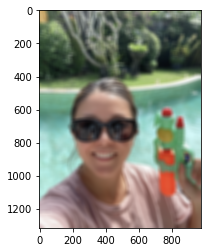

In [ ]:
# (13,13)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (28, 28))

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널 변경
# cv2.COLOR_BGR2RGB: BGR 형식을 RGB 형식으로 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에 Segmentation Mask/img_mask를 이용해서 배경만 추출하겠습니다.

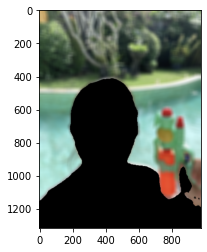

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지 반전.
# 배경이 0 사람이 255 였으나, 연산 후 배경은 255 사람은 0.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하여 배경만 있는 영상 확보
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 5-6. 흐린 배경과 원본 합성하기

[numpy.where](numpy.where) 참고.

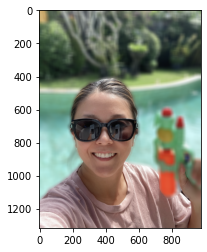

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

인물과 배경 간에 거리 차이가 있으면서 그 거리가 일정할수록 자연스러워 보입니다.

**Q. 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?**

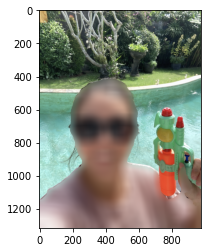

In [ ]:
img_orig_strong_blur = cv2.blur(img_orig, (80, 80))

img_concat = np.where(img_mask_color, img_orig_strong_blur, img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()